# Plot voltage thresholds

Here we show how we can compute the thresholds of several configuratations as voltage values. This is particularly useful when we are in Mixed Wave of Standing Wave propagation modes.

## Set up

Generic libraries:

In [1]:
from functools import partial
from pathlib import Path
import tomllib

import numpy as np

Other libraries required for this notebook:

In [2]:
from multipac_testbench.test_campaign import TestCampaign
import multipac_testbench.instruments as ins
from multipac_testbench.util.post_treaters import running_mean
from multipac_testbench.util.multipactor_detectors import \
    quantity_is_above_threshold

Define the project path, load the configuration.

In [3]:
project = Path("../data/campaign")
config_path = Path(project, "testbench_configuration.toml")

with open(config_path, "rb") as f:
    config = tomllib.load(f)

In [4]:
frequencies = (120., 120., 120., 120., 120.)
swrs = (1., 2., 4., 10., np.inf)
info = ('', '', '', '', 'short-circuit')
filepaths = (
    Path(project, "120MHz_travelling.csv"),
    Path(project, "120MHz_SWR2.csv"),
    Path(project, "120MHz_SWR4.csv"),
    Path(project, "120MHz_SWR10.csv"),
    Path(project, "120MHz_short-circuit.csv")
)
test_campaign = TestCampaign.from_filepaths(filepaths,
                                            frequencies,
                                            swrs,
                                            config,
                                            info=info,
                                            sep='\t')

[INFO    ] [factory.py          ] 1 set of global diagnostics defined:
	GlobalDiagnostic global, with instruments: ['ForwardPower (NI9205_Power1)', 'ReflectedPower (NI9205_Power2)', 'ReflectionCoefficient (Reflection_coefficient)', 'SWR (SWR)', 'Frequency (Reference frequency)']
[INFO    ] [factory.py          ] 10 pick-ups created:
[INFO    ] [factory.py          ] 	Pick-Up E1 at z = 0.000m, with instruments: ['CurrentProbe (NI9205_MP1l)', 'FieldProbe (NI9205_E1)']
[INFO    ] [factory.py          ] 	Pick-Up V1 at z = 0.130m, with instruments: ['Penning (NI9205_Penning1)']
[INFO    ] [factory.py          ] 	Pick-Up E2 at z = 0.260m, with instruments: ['CurrentProbe (NI9205_MP2l)', 'FieldProbe (NI9205_E2)']
[INFO    ] [factory.py          ] 	Pick-Up E3 at z = 0.390m, with instruments: ['CurrentProbe (NI9205_MP3l)', 'FieldProbe (NI9205_E3)']
[INFO    ] [factory.py          ] 	Pick-Up V2 at z = 0.611m, with instruments: ['Penning (NI9205_Penning)']
[INFO    ] [factory.py          ] 	Pick-

Prepare visualisation

In [5]:
ignored_pick_ups = ('E1', 'V1', 'V2', 'V3')
exclude = "NI9205_E1",
to_plot = (ins.CurrentProbe, ins.Power)
figsize = (20, 9)

## Detect multipactor

Smooth the current data

In [6]:
current_smoother = partial(
    running_mean,
    n_mean=10,
    mode='same',
)

test_campaign.add_post_treater(
    current_smoother,
    ins.CurrentProbe,
)

Set a multipactor detection criterion:

In [7]:
current_multipactor_criterions = {'threshold': 12.,
                                  'consecutive_criterion': 10,
                                  'minimum_number_of_points': 7}
current_multipac_detector = partial(quantity_is_above_threshold,
                                    **current_multipactor_criterions)
current_multipactor_bands = test_campaign.detect_multipactor(
    current_multipac_detector,
    ins.CurrentProbe,
)

[WARNING ] [filtering.py        ] There was 32 'True' points in the last 40 points of the ForwardPower array. Setting it to False.
[WARNING ] [filtering.py        ] There was 23 'True' points in the last 40 points of the ForwardPower array. Setting it to False.


## Plot multipactor thresholds as voltages

We plot thresholds for every test, at every pick-up (local detection).

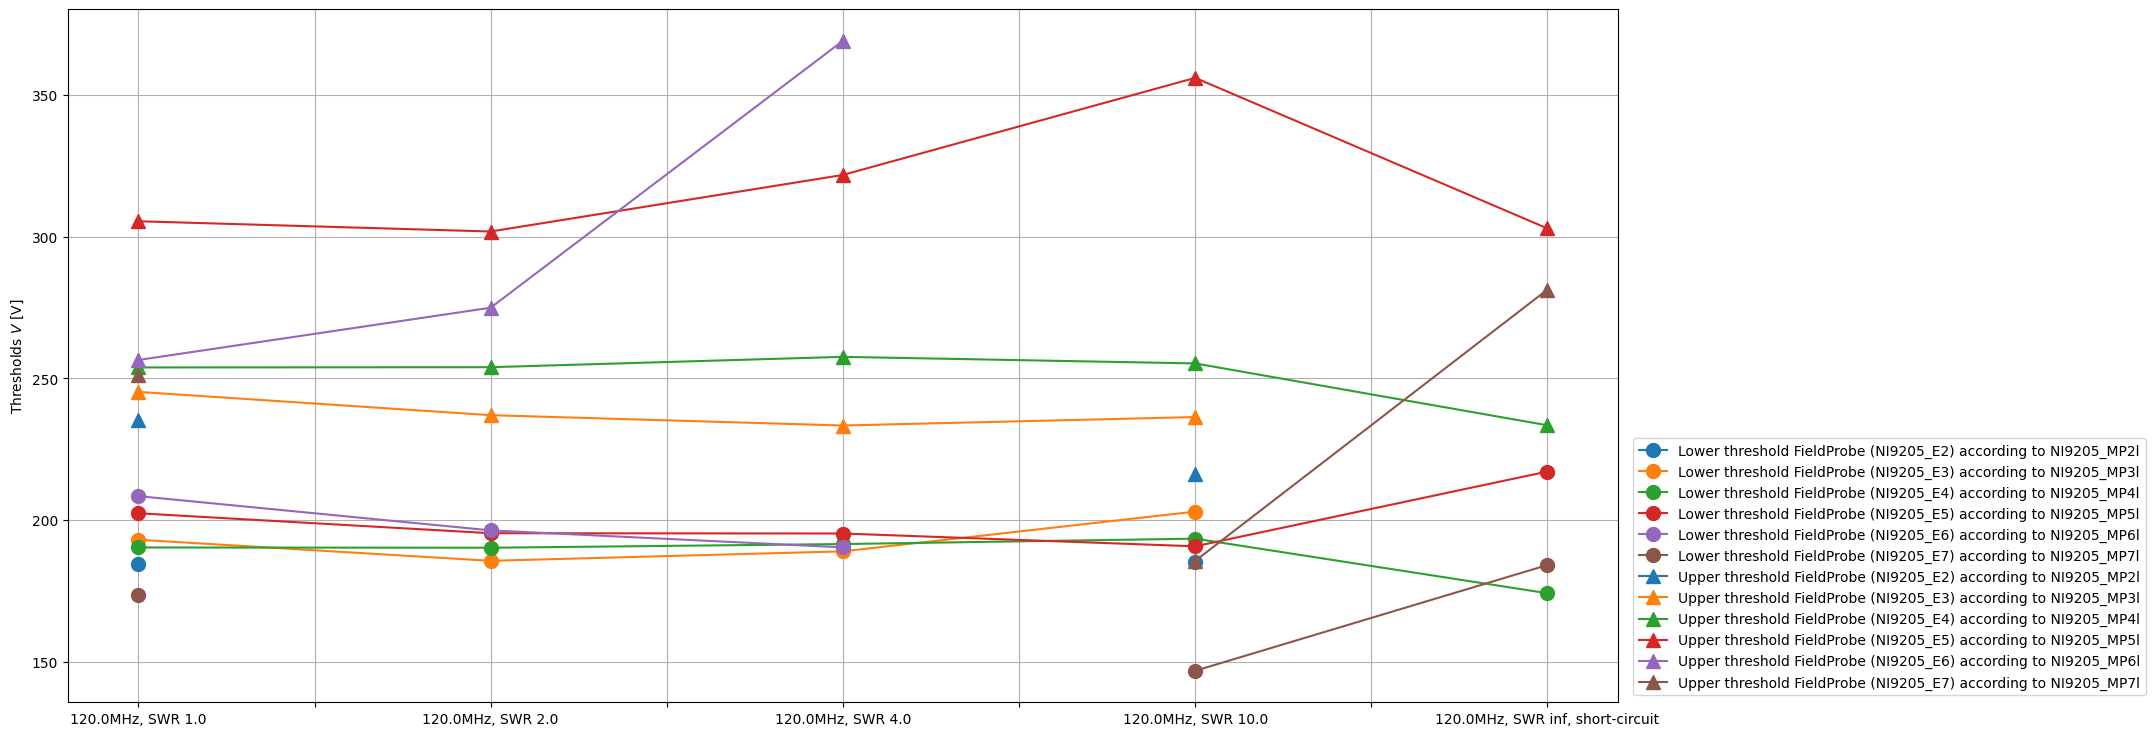

In [8]:
axe, _ = test_campaign.voltage_thresholds(
    current_multipactor_bands,
    measurement_points_to_exclude=ignored_pick_ups,
    figsize=figsize,
)
_ = axe.legend(
    loc=(1.01, 0.01),
    ncol=1,
)